In [ ]:
 # N_TIME_STEPS was orignially 20 changed to 10 for PD test better results # With 20 reaction time accuracy was higher!!
#%tensorflow_version 1.x
#!pip install -q h5py==2.10.0
from scipy.io import loadmat
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [ ]:
# load data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/ActivitiesFIR2(Signal_Selection)/data2.mat")
print(D.keys())

Xi = D['dataC']
Yi = D['des']
L = 987
num = len(Yi)
t = np.arange(0,num*0.01,0.01)

labels=["stand","walk","sit_stand","turn","lie_supine","bend_dyn","lie_side","Fallfwd","Falllat","Fallbwd"]

X_stand = Xi[0:L]
X_walk = Xi[L:2*L]
X_sit = Xi[2*L:3*L]
X_turn = Xi[3*L:4*L]
X_lie = Xi[4*L:5*L]
X_bend = Xi[5*L:6*L]
X_fallf = Xi[7*L:8*L]
X_falll = Xi[8*L:9*L]
X_fallb = Xi[9*L:10*L]

dict_keys(['__header__', '__version__', '__globals__', 'aC', 'aC_b_t', 'aC_in_t', 'aL', 'aL_b_t', 'aL_in_t', 'aR', 'aR_b_t', 'aR_in_t', 'aTL', 'aTL_b_t', 'aTL_in_t', 'aTR', 'aTR_b_t', 'aTR_in_t', 'dataC', 'dataL', 'dataR', 'dataTL', 'dataTR', 'des', 'rollC', 'rollL', 'rollR', 'rollTL', 'rollTR', 'tiltC', 'tiltL', 'tiltR', 'tiltTL', 'tiltTR'])


In [ ]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
from matplotlib import mlab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from numpy.random import default_rng

rng = default_rng()

fs = 10e3
N = 1e5
NFFT = 1024
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

fs = 100
x = X_turn[:,:]

# plt.figure(figsize=(10,12))
# plt.plot(x)
# plt.show()

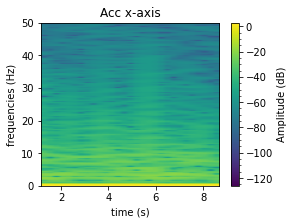

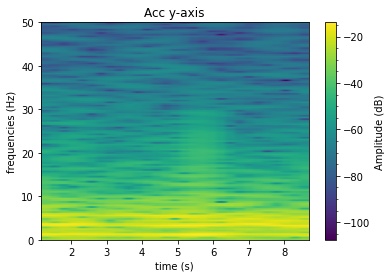

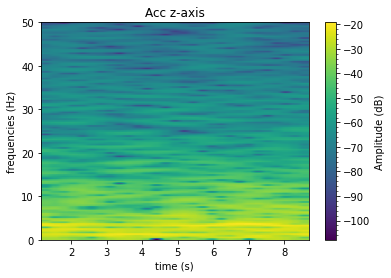

In [ ]:
def specgram2d(y, srate, ax=None, title=None):
  #if not ax:
    ax = plt.axes()
    ax.set_title(title, loc='center', wrap=True)
    spec, freqs, t, im = ax.specgram(y, NFFT=256, Fs=srate, noverlap=230, scale='dB' )#,cmap='gray'
    ax.set_xlabel('time (s)')
    ax.set_ylabel('frequencies (Hz)')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Amplitude (dB)')
    cbar.minorticks_on()
    return spec, freqs, t, im
fig1, ax1 = plt.subplots(figsize=(4, 3))
spec0, freqs, t, im = specgram2d(x[:,0], srate=100, ax=ax1, title='Acc x-axis') # Turning
plt.show()
spec1, freqs, t, im = specgram2d(x[:,1], srate=100, ax=ax1, title='Acc y-axis')# Turning
plt.show()
spec2, freqs, t, im = specgram2d(x[:,2], srate=100, ax=ax1, title='Acc z-axis')# Turning
plt.show()

spec0 = 10*np.log10(spec0)# - np.min(spec))/np.max(spec)
spec1 = 10*np.log10(spec1)
spec2 = 10*np.log10(spec2)

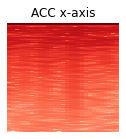

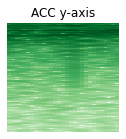

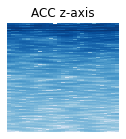

In [ ]:
# print(spec[0,:])
plt.figure(figsize=(2, 2))# plt.figure(figsize=(4, 4))
plt.imshow(spec0, cmap='Reds', interpolation='nearest', aspect='auto')
plt.title('ACC x-axis')
plt.axis('off')
plt.show()

plt.figure(figsize=(2, 2))# plt.figure(figsize=(4, 4))
plt.imshow(spec1, cmap='Greens', interpolation='nearest', aspect='auto')
plt.title('ACC y-axis')
plt.axis('off')
plt.show()

plt.figure(figsize=(2, 2))# plt.figure(figsize=(4, 4))
plt.imshow(spec2, cmap='Blues', interpolation='nearest', aspect='auto')
plt.title('ACC z-axis')
plt.axis('off')
plt.show()

(129, 29, 3)


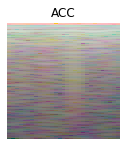

In [ ]:
spec = np.dstack((spec0, spec1))
spec = np.dstack((spec, spec2))

spec -= np.min(spec)
spec /= np.amax(spec)

print(spec.shape)

plt.figure(figsize=(2.02, 2.13))# plt.figure(figsize=(4.02, 4.13))
plt.imshow(spec, interpolation='nearest', aspect='auto')
plt.title('ACC')
plt.axis('off')
plt.savefig('image.png', bbox_inches='tight',pad_inches = 0)
plt.show()


In [ ]:
# function to convert a (n x 3) matrix to an RGB sepctogram image
def spec2img(x, srate, title=None):
  def x2specgram(x,srate):
    spec, freqs, t, im = plt.specgram(x, NFFT=256, Fs=srate, noverlap=240, scale='dB',cmap='gray' )
    plt.close()
    return spec[:50,:], freqs, t, im
  # extract spectogram for the each signal
  spec0, freqs, t, im = x2specgram(x[:,0], srate)
  spec1, freqs, t, im = x2specgram(x[:,1], srate)
  spec2, freqs, t, im = x2specgram(x[:,2], srate)

  # scale to db
  spec0 = 10*np.log10(spec0)# - np.min(spec))/np.max(spec)
  spec1 = 10*np.log10(spec1)
  spec2 = 10*np.log10(spec2)

  # stack to make 3d array
  spec = np.dstack((spec0, spec1))
  spec = np.dstack((spec, spec2))

  # correct range from 0 to 1
  spec -= np.min(spec)
  spec /= np.amax(spec)
  print(spec.shape)

  # plot image
  plt.figure(figsize=(2, 2)) # 4,4
  plt.imshow(spec, interpolation='nearest', aspect='auto')
  plt.title(title)
  plt.axis('off')
  plt.show()

  return spec

(50, 16, 3)


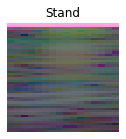

(50, 46, 3)


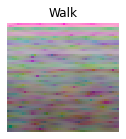

(50, 46, 3)


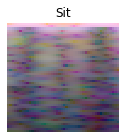

(50, 46, 3)


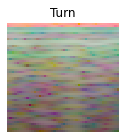

(50, 46, 3)


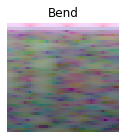

(50, 46, 3)


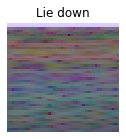

(50, 46, 3)


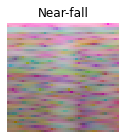

In [ ]:
# spec_walk = spec2img(X_stand[0:500,:], 100, 'Stand ACC')
# spec_walk = spec2img(X_walk, 100, 'Walk ACC')
# spec_walk = spec2img(X_sit, 100, 'Sit ACC')
# spec_walk = spec2img(X_turn, 100, 'Turn ACC')
# spec_walk = spec2img(X_bend, 100, 'Bend ACC')
# spec_walk = spec2img(X_lie, 100, 'Lie down ACC')
# spec_walk = spec2img(X_fallf, 100, 'Nfall fwd ACC')
# spec_walk = spec2img(X_falll, 100, 'Nfall lat ACC')
# spec_walk = spec2img(X_fallb, 100, 'Nfall bwd ACC')

spec_walk = spec2img(X_stand[0:500,:], 100, 'Stand')
spec_walk = spec2img(X_walk, 100, 'Walk')
spec_walk = spec2img(X_sit, 100, 'Sit')
spec_walk = spec2img(X_turn, 100, 'Turn')
spec_walk = spec2img(X_bend, 100, 'Bend')
spec_walk = spec2img(X_lie, 100, 'Lie down')
spec_walk = spec2img(X_fallf, 100, 'Near-fall')



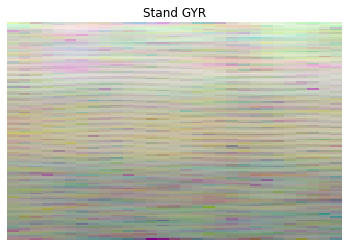

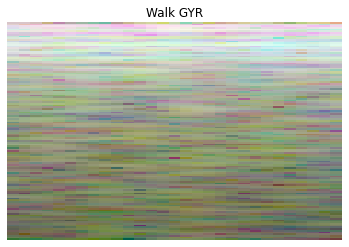

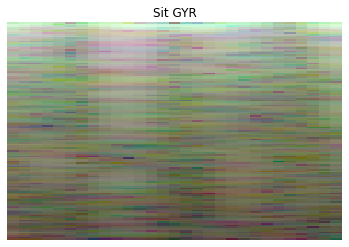

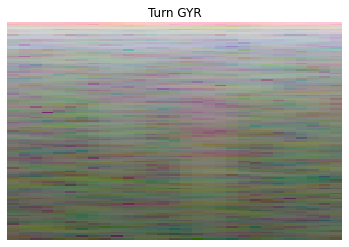

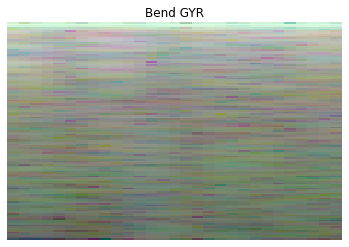

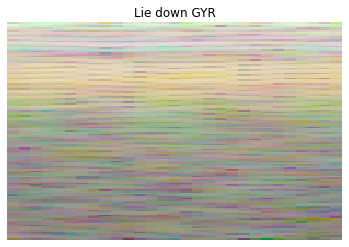

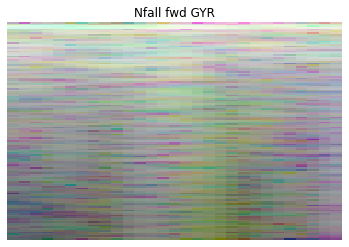

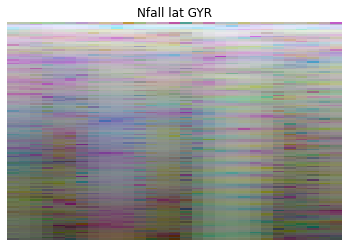

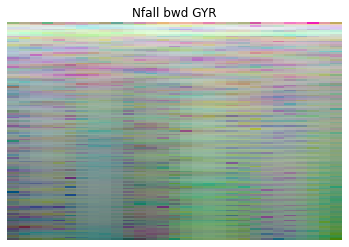

In [ ]:
spec_walk = spec2img(X_stand[:,3:], 100, 'Stand GYR')
spec_walk = spec2img(X_walk[:,3:], 100, 'Walk GYR')
spec_walk = spec2img(X_sit[:,3:], 100, 'Sit GYR')
spec_walk = spec2img(X_turn[:,3:], 100, 'Turn GYR')
spec_walk = spec2img(X_bend[:,3:], 100, 'Bend GYR')
spec_walk = spec2img(X_lie[:,3:], 100, 'Lie down GYR')
spec_walk = spec2img(X_fallf[:,3:], 100, 'Nfall fwd GYR')
spec_walk = spec2img(X_falll[:,3:], 100, 'Nfall lat GYR')
spec_walk = spec2img(X_fallb[:,3:], 100, 'Nfall bwd GYR')

In [ ]:
# load data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/ActivitiesFIR2(Signal_Selection)/ForImageNet.mat")
print(D.keys())

cell = D['cell']
Categ = D['cell_cat']

cell = np.squeeze(cell)
# X = np.empty((cell.shape[0]-1, cell[0].shape[0], cell[0].shape[1], cell[0].shape[2]))
# for i in range(X.shape[0]-1):
#     X[i] = cell[i]

labels=Categ#["stand","walk","sit","sit_stand","turn","lie_supine","bend_dyn","nFallfwd","nFalllat","nFallbwd"]

X_stand = cell[0]
X_walk = cell[1]
X_sitStand = cell[2]
X_turn = cell[3]
X_lie = cell[4]
X_bend = cell[5]
X_nfall = cell[6]

print(X_stand.shape)
print(X_nfall.shape)

dict_keys(['__header__', '__version__', '__globals__', 'cell', 'cell_cat'])
(470, 500, 6)
(71, 500, 6)


In [ ]:
import os
# save images of the data generated by spectrograms
# function to convert a (n x 3) matrix to an RGB sepctogram image w/o plotting
def x2specgram(x,srate):
    spec, freqs, t, im = plt.specgram(x, NFFT=256, Fs=srate, noverlap=240, scale='dB',cmap='gray' )
    plt.close()
    return spec[:50,:]

def spec2img2(x, srate):

  # extract spectogram for the each signal
  spec0 = x2specgram(x[:,0], srate)
  spec1 = x2specgram(x[:,1], srate)
  spec2 = x2specgram(x[:,2], srate)

  # scale to db
  spec0 = 10*np.log10(spec0)# - np.min(spec))/np.max(spec)
  spec1 = 10*np.log10(spec1)
  spec2 = 10*np.log10(spec2)

  # stack to make 3d array
  spec = np.dstack((spec0, spec1))
  spec = np.dstack((spec, spec2))

  # correct range from 0 to 1
  spec -= np.min(spec)
  spec /= np.amax(spec)

  return spec

# save image function
def spec2save(x, srate, title, dir):
  for i in range(3,x.shape[0]):
    spec = spec2img2(x[i], srate)
    plt.figure(figsize=(4.02, 4.13))
    plt.axis('off')
    plt.imshow(spec, interpolation='nearest', aspect='auto')
    if i%3==0:
      path = dir + "/val/" + title + '/'
    else:
      path = dir + "/train/" + title + '/'
    try:
      os.makedirs(path)
      plt.savefig(path + str(i) + ".png", bbox_inches='tight',pad_inches = 0)
    except:
      plt.savefig(path + str(i) + ".png", bbox_inches='tight',pad_inches = 0)

# save image function
def spec2saveGyro(x, srate, title, dir):
  for i in range(3,x.shape[0]):
    spec = spec2img2(x[i][:,3:], srate)
    plt.figure(figsize=(4.02, 4.13))
    plt.axis('off')
    plt.imshow(spec, interpolation='nearest', aspect='auto')
    if i%3==0:
      path = "drive/MyDrive/Thesis/Codes/ImageNet/dataGyrTest/val/" + title + '/'
    else:
      path = "drive/MyDrive/Thesis/Codes/ImageNet/dataGyrTest/train/" + title + '/'
    try:
      os.makedirs(path)
      plt.savefig(path + str(i) + ".png", bbox_inches='tight',pad_inches = 0)
    except:
      plt.savefig(path + str(i) + ".png", bbox_inches='tight',pad_inches = 0)

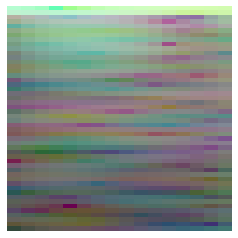

In [ ]:
spec2save(X_stand, 100, 'stand')
spec2save(X_walk, 100, 'walk')
#spec2save(X_sit, 100, 'sit')
spec2save(X_sitStand, 100, 'sitstand')
spec2save(X_turn, 100, 'turn')
spec2save(X_lie, 100, 'lie')
spec2save(X_bend, 100, 'bend')
spec2save(X_nfall, 100, 'nfall')

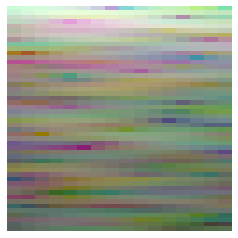

In [ ]:
spec2saveGyro(X_stand, 100, 'stand')
spec2saveGyro(X_walk, 100, 'walk')
#spec2saveGyro(X_sit, 100, 'sit')
spec2saveGyro(X_sitStand, 100, 'sitstand')
spec2saveGyro(X_turn, 100, 'turn')
spec2saveGyro(X_lie, 100, 'lie')
spec2saveGyro(X_bend, 100, 'bend')
spec2saveGyro(X_nfall, 100, 'nfall')

In [ ]:
## load TEST data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/ActivitiesFIR2(Signal_Selection)/ForImageNetTest2.mat")
print(D.keys())

cell = D['cell']
Categ = D['cell_cat']

cell = np.squeeze(cell)
labels=Categ

X_stand = cell[0]
X_walk = cell[1]
X_sitStand = cell[2]
X_turn = cell[3]
X_lie = cell[4]
X_bend = cell[5]
X_nfall = cell[6]

print(X_stand.shape)
print(X_nfall.shape)

dict_keys(['__header__', '__version__', '__globals__', 'cell', 'cell_cat'])
(30, 500, 6)
(90, 500, 6)


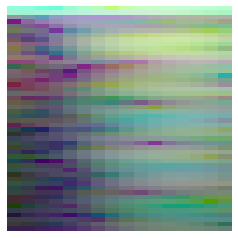

In [ ]:
dir = 'drive/MyDrive/Thesis/Codes/ImageNet/dataAccTest2'
spec2save(X_stand, 100, 'stand', dir)
spec2save(X_walk, 100, 'walk', dir)
#spec2save(X_sit, 100, 'sit')
spec2save(X_sitStand, 100, 'sitstand', dir)
spec2save(X_turn, 100, 'turn', dir)
spec2save(X_lie, 100, 'lie', dir)
spec2save(X_bend, 100, 'bend', dir)
spec2save(X_nfall, 100, 'nfall', dir)

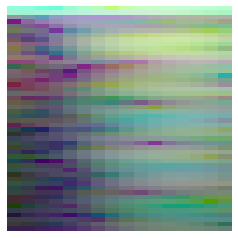

In [ ]:
dir = 'drive/MyDrive/Thesis/Codes/ImageNet/dataGyrTest2'
spec2save(X_stand, 100, 'stand', dir)
spec2save(X_walk, 100, 'walk', dir)
#spec2save(X_sit, 100, 'sit')
spec2save(X_sitStand, 100, 'sitstand', dir)
spec2save(X_turn, 100, 'turn', dir)
spec2save(X_lie, 100, 'lie', dir)
spec2save(X_bend, 100, 'bend', dir)
spec2save(X_nfall, 100, 'nfall', dir)

In [ ]:
## load HG data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/ActivitiesFIR2(Signal_Selection)/ForImageNet_HG_corrected.mat")
print(D.keys())

cell = D['cell']
Categ = D['cell_cat']

cell = np.squeeze(cell)
labels=Categ

X_stand = cell[0]
X_walk = cell[1]
X_sitStand = cell[2]
X_turn = cell[3]
X_lie = cell[4]
X_bend = cell[5]
X_nfall = cell[6]

print(X_stand.shape)
print(X_nfall.shape)

dict_keys(['__header__', '__version__', '__globals__', 'cell', 'cell_cat'])
(470, 500, 3)
(71, 500, 3)


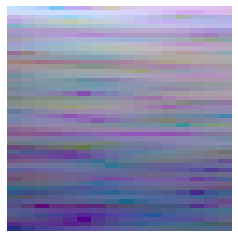

In [ ]:
spec2save(X_stand, 100, 'stand')
spec2save(X_walk, 100, 'walk')
#spec2save(X_sit, 100, 'sit')
spec2save(X_sitStand, 100, 'sitstand')
spec2save(X_turn, 100, 'turn')
spec2save(X_lie, 100, 'lie')
spec2save(X_bend, 100, 'bend')
spec2save(X_nfall, 100, 'nfall')

In [ ]:
## load Test HG data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/ActivitiesFIR2(Signal_Selection)/ForImageNetTest_HG.mat")
print(D.keys())

cell = D['cell']
Categ = D['cell_cat']

cell = np.squeeze(cell)
labels=Categ

X_stand = cell[0]
X_walk = cell[1]
X_sitStand = cell[2]
X_turn = cell[3]
X_lie = cell[4]
X_bend = cell[5]
X_nfall = cell[6]

print(X_stand.shape)
print(X_nfall.shape)

dict_keys(['__header__', '__version__', '__globals__', 'cell', 'cell_cat'])
(30, 500, 3)
(90, 500, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


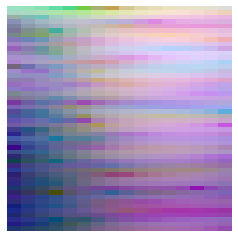

In [ ]:
dir = 'drive/MyDrive/Thesis/Codes/ImageNet/dataHGTest'
spec2save(X_stand, 100, 'stand', dir)
spec2save(X_walk, 100, 'walk', dir)
#spec2save(X_sit, 100, 'sit')
spec2save(X_sitStand, 100, 'sitstand', dir)
spec2save(X_turn, 100, 'turn', dir)
spec2save(X_lie, 100, 'lie', dir)
spec2save(X_bend, 100, 'bend', dir)
spec2save(X_nfall, 100, 'nfall', dir)

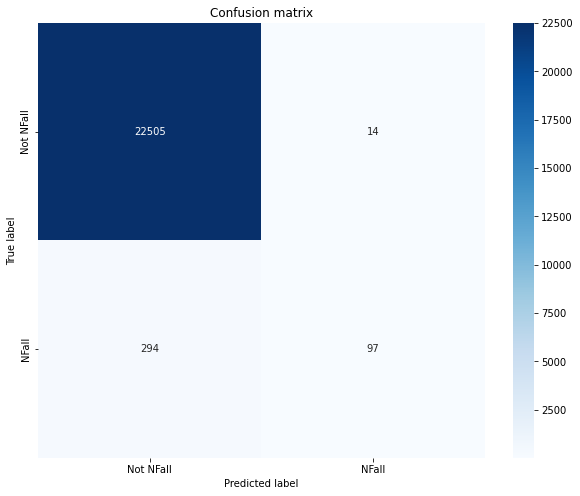

In [ ]:
LABELS = ['Not NFall','NFall']
Y_cat = np.argmax(Y_binary, axis=1)
Y_pred_int = np.argmax(Y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(Y_cat, Y_pred_int)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [ ]:
# accuracy of Nfall detection
599/(599+83)*100

87.82991202346041

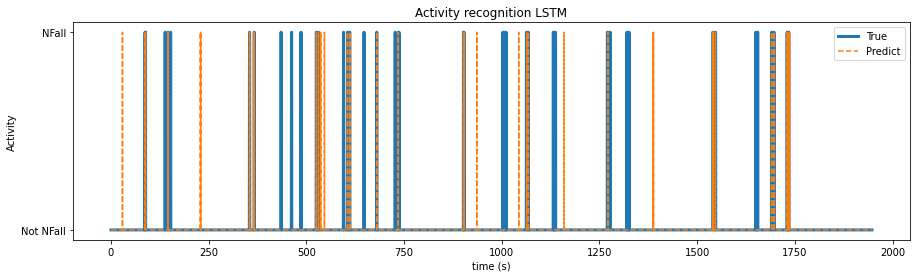

In [ ]:
def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(15, 4))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=3.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--')
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y)
tt = np.arange(0,num*0.085,0.085)
visualize_activity_recognition(tt, Y, Y_pred_int, LABELS,"LSTM")

In [ ]:
# transform data back to time
Y_time = np.zeros(np.shape(Yi))
for i in range(0, len(Y_pred_int), 1):
    Y_time[i*step: i*step + N_TIME_STEPS] = Y_pred_int[i]*np.ones((N_TIME_STEPS,1))


In [ ]:
#np.shape(Y_edge)
#print(Y_time[1:10])

In [ ]:
# test data and performance in Rxn time
Y_test = Y_time[90000:]
Y_test_shift = Y_time[90001:]
Y_test_shift=np.append(Y_test_shift,[[0]],axis=0)

Y_test_true = Yi[90000:]
Y_test_true_shift = Yi[90001:]
Y_test_true_shift=np.append(Y_test_true_shift,[[0]],axis=0)

# edge positions
Y_edge = Y_test_shift - Y_test
rise_idx = [i for i, j in enumerate(Y_edge) if j == 1]
fall_idx = [i for i, j in enumerate(Y_edge) if j == -1]
rxn_time = (np.array(fall_idx)-np.array(rise_idx))/60

Y_edge_true = Y_test_true_shift - Y_test_true
rise_idx_true = [i for i, j in enumerate(Y_edge_true) if j == 1]
fall_idx_true = [i for i, j in enumerate(Y_edge_true) if j == -1]
rxn_time_true = (np.array(fall_idx_true)-np.array(rise_idx_true))/60

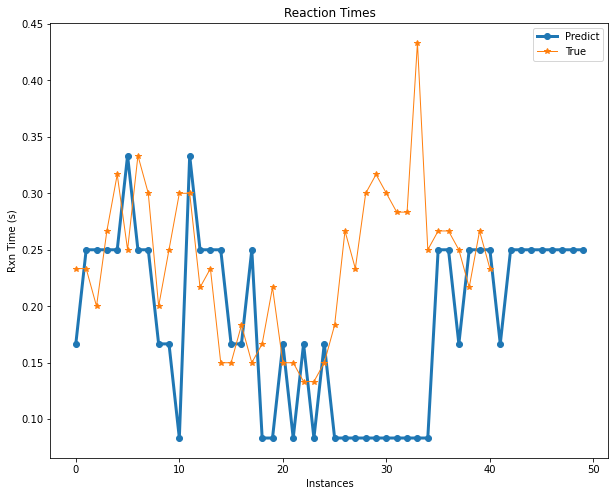

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Reaction Times")
plt.plot(rxn_time[:], 'o-',linewidth=3.0)
plt.plot(rxn_time_true[:], '-*', linewidth=1.0)
plt.xlabel("Instances")
plt.ylabel("Rxn Time (s)")
plt.legend(["Predict","True"])
plt.show()

In [ ]:
Y_test = Y_time
Y_test_shift = Y_time[1:]
Y_test_shift=np.append(Y_test_shift,[[0]],axis=0)

# edge positions
Y_edge = Y_test_shift - Y_test
rise_idx = [i for i, j in enumerate(Y_edge) if j == 1]
fall_idx = [i for i, j in enumerate(Y_edge) if j == -1]
mid_idx = np.round((np.array(rise_idx)+np.array(fall_idx))/2).astype(int)
rxn_time = (np.array(fall_idx)-np.array(rise_idx))/60

Y_test_true = Yi
Y_test_true_shift = Yi[1:]
Y_test_true_shift=np.append(Y_test_true_shift,[[0]],axis=0)

Y_edge_true = Y_test_true_shift - Y_test_true
rise_idx_true = [i for i, j in enumerate(Y_edge_true) if j == 1]
fall_idx_true = [i for i, j in enumerate(Y_edge_true) if j == -1]
mid_idx_true = np.round((np.array(rise_idx_true)+np.array(fall_idx_true))/2).astype(int)
rxn_time_true = (np.array(fall_idx_true)-np.array(rise_idx_true))/60

rxn_time_corrected = []
rxn_time_true_corrected = []
Y_edge = Y_edge.tolist()
for i in range(mid_idx_true.shape[0]):
  if Y_test[mid_idx_true[i]]==1:
    fall_c = Y_edge[mid_idx_true[i]:].index([-1.0]) + mid_idx_true[i]
    rise_c = mid_idx_true[i] - Y_edge[mid_idx_true[i]::-1].index([1.0])
    rxn_time_c = fall_c - rise_c
    rxn_time_corrected.append(rxn_time_c/60)
    rxn_time_true_corrected.append(rxn_time_true[i])


In [ ]:
a=rise_idx_true+fall_idx_true

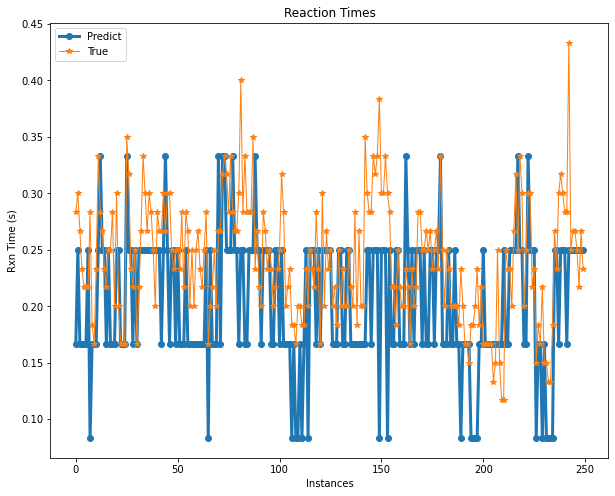

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Reaction Times")
plt.plot(rxn_time_corrected[:], 'o-',linewidth=3.0)
plt.plot(rxn_time_true_corrected[:], '-*', linewidth=1.0)
plt.xlabel("Instances")
plt.ylabel("Rxn Time (s)")
plt.legend(["Predict","True"])
plt.show()

In [ ]:
#rxn_accuracy = 1-np.mean(np.abs((rxn_time[:]-rxn_time_true[:-4])/rxn_time_true[:-4]))
#print(rxn_accuracy)

In [ ]:
rxn_accuracy = 1-np.mean(np.abs((np.array(rxn_time_corrected)-np.array(rxn_time_true_corrected))/np.array(rxn_time_true_corrected)))
print(rxn_accuracy)

0.7851188556586322


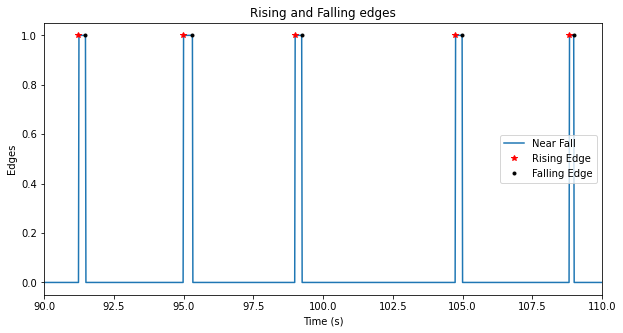

In [ ]:

plt.figure(figsize=(10, 5))
plt.title("Rising and Falling edges")
plt.plot(t, Y_time)
plt.plot(t[rise_idx],np.ones((len(rise_idx),1)), 'r*', linewidth=5.0)
plt.plot(t[fall_idx],np.ones((len(fall_idx),1)), 'k.', linewidth=5.0)
plt.xlabel("Time (s)")
plt.ylabel("Edges")
plt.legend(["Near Fall","Rising Edge","Falling Edge"])
plt.xlim(90,110) #plt.xlim(0,2000)
plt.show()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y', 'YCOM', 'YE', 'YFoot', 't'])


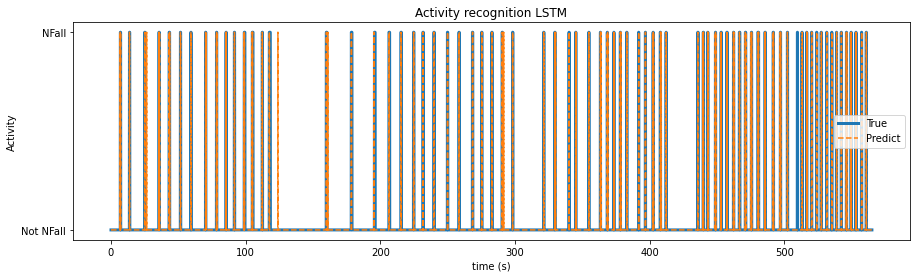

In [ ]:
# try on PD pull tests
# load data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/Pull Tests/PD/data_PD.mat")
print(D.keys())

Xi2 = D['X']
Yi2 = D['Y']
t2 = D['t']

Xi2 = Xi2[:,0:7]
Xi2[:,0:2] *= -1
Xi2[:,3:5] *= -1

N_TIME_STEPS = 10
step = 1 # faster with bigger step but accuracy degrades fast
X2 = []
Y2 = []
for i in range(0, len(Yi2) - N_TIME_STEPS, step):
    part = Xi2[i: i + N_TIME_STEPS]
    label = stats.mode(Yi2[i: i + N_TIME_STEPS])[0][0]
    X2.append(part)
    Y2.append(label)
Y_binary2 = to_categorical(Y2)

# reshape data into time steps of sub-sequences
X2 = np.array(X2)
n_features, n_steps, n_length = X2.shape[2], 2, 5
testX2 = X2.reshape((X2.shape[0], n_steps, 1, n_length, n_features))
Y_pred2 = model.predict(np.array(testX2))
Y_pred_int2 = np.argmax(Y_pred2, axis=1)

def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(15, 4))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=3.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--')
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y2)
tt2 = np.arange(0,num*0.017,0.017)
visualize_activity_recognition(tt2, Y2, Y_pred_int2, LABELS,"LSTM")

In [ ]:
print('Correct detection accuracy: ',1-1/67)
print('Wrong detection error: ',3/67)

Correct detection accuracy:  0.9850746268656716
Wrong detection error:  0.04477611940298507


dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y', 'Y2'])


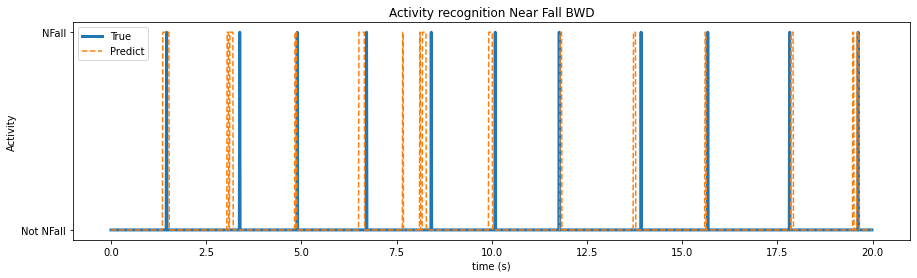

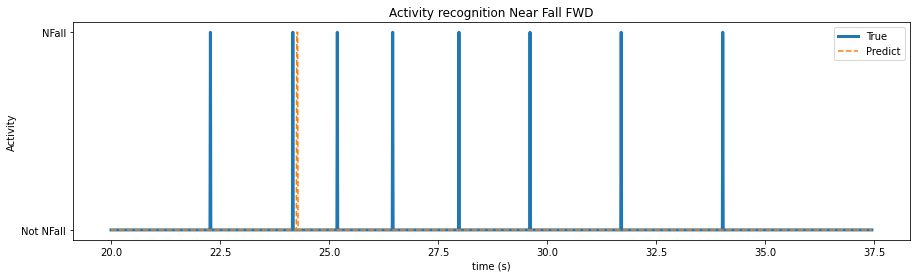

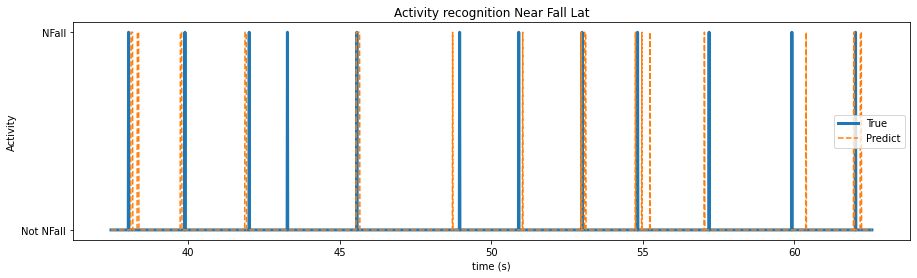

In [ ]:
# try on mine near fall simulations
# load data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/Pull Tests/Mine/data.mat")
print(D.keys())

Xi2 = D['X']
Yi2 = D['Y']

Xi2 = Xi2[:,0:7]
#Xi2[:,0:2] *= -1
#Xi2[:,3:5] *= -1

N_TIME_STEPS = 10
step = 1 # faster with bigger step but accuracy degrades fast
X2 = []
Y2 = []
for i in range(0, len(Yi2) - N_TIME_STEPS, step):
    part = Xi2[i: i + N_TIME_STEPS]
    label = stats.mode(Yi2[i: i + N_TIME_STEPS])[0][0]
    X2.append(part)
    Y2.append(label)
Y_binary2 = to_categorical(Y2)

# reshape data into time steps of sub-sequences
X2 = np.array(X2)
n_features, n_steps, n_length = X2.shape[2], 2, 5
testX2 = X2.reshape((X2.shape[0], n_steps, 1, n_length, n_features))
Y_pred2 = model.predict(np.array(testX2))
Y_pred_int2 = np.argmax(Y_pred2, axis=1)

def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(15, 4))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=3.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--')
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y2)
tt2 = np.arange(0,num*0.01,0.01)
# actually fwd but since axis are revert it is like BWD
visualize_activity_recognition(tt2[:1999], Yi2[:1999], Y_pred_int2[:1999], LABELS,"Near Fall BWD")


visualize_activity_recognition(tt2[2000:2000+1746], Yi2[2000:2000+1746], Y_pred_int2[2000:2000+1746], LABELS,"Near Fall FWD")


visualize_activity_recognition(tt2[2000+1746:], Yi2[2000+1746:-10], Y_pred_int2[2000+1746:], LABELS,"Near Fall Lat")

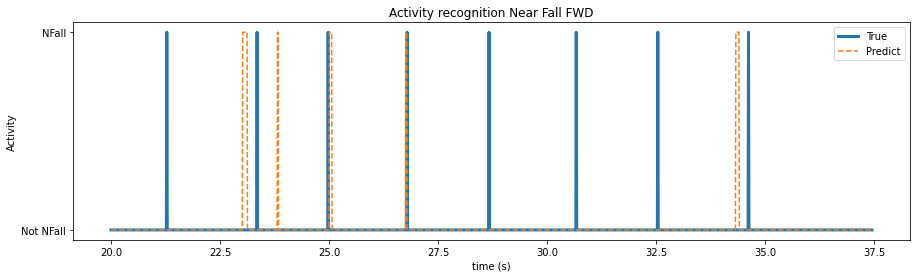

In [ ]:
Xi2 = D['X']
Yi2 = D['Y2']

Xi2 = Xi2[:,0:7]
#Xi2[:,[1,0]] = Xi2[:,[0,1]]
#Xi2[:,[3,4]] = Xi2[:,[4,3]]
Xi2[:,0:2] *= -1.0
Xi2[:,3:5] *= -1.0
Xi2[:,6] *= -1

N_TIME_STEPS = 10
step = 1 # faster with bigger step but accuracy degrades fast
X2 = []
Y2 = []
for i in range(0, len(Yi2) - N_TIME_STEPS, step):
    part = Xi2[i: i + N_TIME_STEPS]
    label = stats.mode(Yi2[i: i + N_TIME_STEPS])[0][0]
    X2.append(part)
    Y2.append(label)
Y_binary2 = to_categorical(Y2)

# reshape data into time steps of sub-sequences
X2 = np.array(X2)
n_features, n_steps, n_length = X2.shape[2], 2, 5
testX2 = X2.reshape((X2.shape[0], n_steps, 1, n_length, n_features))
Y_pred2 = model.predict(np.array(testX2))
Y_pred_int2 = np.argmax(Y_pred2, axis=1)


num = len(Y2)
tt2 = np.arange(0,num*0.01,0.01)
# actually bwd but since axis are revert it is like FWD
visualize_activity_recognition(tt2[2000:2000+1746], Yi2[2000:2000+1746], Y_pred_int2[2000:2000+1746], LABELS,"Near Fall FWD")